In [522]:

import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping


In [523]:
import os 
import pandas as pd
import shutil

dataset_path = r"/Neurociencias-2025-2/S03_datasets/Brain_tumor/Brain Tumor/Brain Tumor"
csv_path = os.path.join(dataset_path, "Brain_Tumor.csv")

df = pd.read_csv(csv_path)

#lista todos los nombres de las imágenes
all_images = sorted([f for f in os.listdir(dataset_path) if f.lower().endswith('.jpg')])

#verificar que el número de imágenes coincida con las filas del CSV
assert len(all_images) == len(df), "El número de imágenes no coincide con el número de filas en el CSV."

df["Image"] = all_images

# Carpetas base
train_dir = os.path.join(dataset_path, "TRAIN")
val_dir = os.path.join(dataset_path, "VAL")

# Crear subcarpetas si no existen
for folder in ["tumor", "no_tumor"]:
    os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, folder), exist_ok=True)

# Carpeta donde están realmente las imágenes
all_images_dir = dataset_path  # <- cámbiala si están en otra subcarpeta

# Distribuir imágenes
not_found = []

for _, row in df.iterrows():
    image_name = str(row["Image"]) 
    label = str(row["Class"])  # "1" o "0"
    
    src_path = os.path.join(all_images_dir, image_name)

    if not os.path.exists(src_path):
        not_found.append(image_name)
        continue

    # Separar TRAIN y VAL, por ejemplo 80/20
    if hash(image_name) % 5 == 0:
        dest_folder = os.path.join(val_dir, "tumor" if label == "1" else "no_tumor")
    else:
        dest_folder = os.path.join(train_dir, "tumor" if label == "1" else "no_tumor")

    shutil.copy(src_path, os.path.join(dest_folder, image_name))

print(f"✅ Imágenes organizadas. No encontradas: {len(not_found)}")

if not_found:
    print("⚠️ Estas imágenes no se encontraron:")
    print(not_found[:10])  # muestra solo las primeras 10


✅ Imágenes organizadas. No encontradas: 0


In [524]:
# visualizar el csv 
print("Primeras filas del CSV:")
df.head()

Primeras filas del CSV:


,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1.jpg,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image10.jpg,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image100.jpg,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image1000.jpg,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image1001.jpg,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


#

In [525]:
tumor_dir = os.path.join(train_dir, "tumor")
no_tumor_dir = os.path.join(train_dir, "no_tumor")
tumor_val_dir = os.path.join(val_dir, "tumor")
no_tumor_val_dir = os.path.join(val_dir, "no_tumor")

def contar_imagenes(carpeta):
    return len([nombre for nombre in os.listdir(carpeta) if nombre.endswith(".jpg")])

print("TRAIN")
print(f"Tumor: {contar_imagenes(tumor_dir)} imágenes")
print(f"No Tumor: {contar_imagenes(no_tumor_dir)} imágenes")

print("\nVALIDACIÓN")
print(f"Tumor: {contar_imagenes(tumor_val_dir)} imágenes")
print(f"No Tumor: {contar_imagenes(no_tumor_val_dir)} imágenes")


TRAIN
Tumor: 1318 imágenes
No Tumor: 1674 imágenes

VALIDACIÓN
Tumor: 365 imágenes
No Tumor: 405 imágenes


In [526]:
train_dir = r"/Neurociencias-2025-2/S03_datasets/Brain_tumor/Brain Tumor/Brain Tumor/TRAIN"
val_dir = r"/Neurociencias-2025-2/S03_datasets/Brain_tumor/Brain Tumor/Brain Tumor/VAL"

In [527]:
img_size = (128, 128)
batch_size = 32

# Aumentación solo para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Carga de imágenes
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Usa la variable train_dir definida en la celda 1
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,  # Usa la variable val_dir definida en la celda 1
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

Found 2992 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


## CNN

In [528]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape =  (128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation = 'relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(120, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = "sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stop]
)
print("Accuracy", history.history["val_accuracy"][-1])

/Users/alisson/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/alisson/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 452ms/step - accuracy: 0.5250 - loss: 0.7220 - val_accuracy: 0.5260 - val_loss: 0.6916
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - accuracy: 0.5516 - loss: 0.6892 - val_accuracy: 0.5260 - val_loss: 0.6914
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 471ms/step - accuracy: 0.5647 - loss: 0.6839 - val_accuracy: 0.5221 - val_loss: 0.6916
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 453ms/step - accuracy: 0.5677 - loss: 0.6837 - val_accuracy: 0.5195 - val_loss: 0.6905
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 469ms/step - accuracy: 0.5472 - loss: 0.6880 - val_accuracy: 0.5247 - val_loss: 0.6901
Accuracy 0.5246753096580505


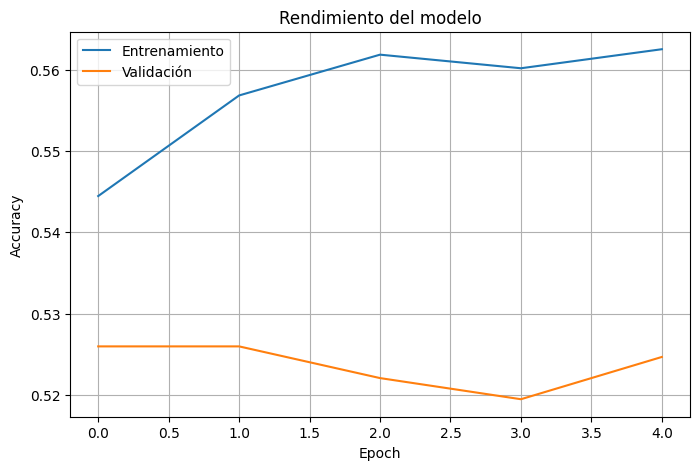

In [542]:
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Entrenamiento")
plt.plot(history.history["val_accuracy"], label="Validación")
plt.title("Rendimiento del modelo")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Nuevas medidas 

In [531]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE   = (128, 128)
BATCH_SIZE  = 32

aug_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

plain_val  = ImageDataGenerator(rescale=1./255)

train_generator = aug_train.flow_from_directory(
    train_dir,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = plain_val.flow_from_directory(
    val_dir,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
from tensorflow.keras.layers import (Conv2D, MaxPooling2D,
                                     Flatten, Dense, Dropout)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

def cnn_a():
    net = Sequential([
        Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(*IMG_SHAPE, 3)),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.50),
        Dense(1, activation='sigmoid')
    ])
    return net

def cnn_b():
    net = Sequential([
        Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(*IMG_SHAPE, 3)),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.40),
        Dense(1, activation='sigmoid')
    ])
    return net

def cnn_c():
    net = Sequential([
        Conv2D(64,  (3,3), padding='same', activation='relu', input_shape=(*IMG_SHAPE, 3)),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(256, (3,3), padding='same', activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.35),
        Dense(1, activation='sigmoid')
    ])
    return net

model_pack   = [cnn_a(), cnn_b(), cnn_c()]
epochs_pack  = [5, 5, 5]
log_metrics  = []

early = EarlyStopping(monitor='val_loss',
                      patience=5,
                      restore_best_weights=True,
                      verbose=1)

for net, n_epochs in zip(model_pack, epochs_pack):

    net.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

    h = net.fit(
        train_generator,
        validation_data=val_generator,
        epochs=n_epochs,
        callbacks=[early],
        verbose=1
    )

    train_acc = h.history['accuracy'][-1]
    val_acc   = h.history['val_accuracy'][-1]

    log_metrics.append({
        'épocas': n_epochs,
        'acc_entrenamiento': round(train_acc, 4),
        'acc_validación':   round(val_acc,   4)
    })

for fila in log_metrics:
    print(f"Ep:{fila['épocas']:>2} | "
          f"train_acc={fila['acc_entrenamiento']:.4f} | "
          f"val_acc={fila['acc_validación']:.4f}")

Found 2992 images belonging to 2 classes.
Found 770 images belonging to 2 classes.


/Users/alisson/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/alisson/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 343ms/step - accuracy: 0.5373 - loss: 0.7219 - val_accuracy: 0.5260 - val_loss: 0.6914
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 396ms/step - accuracy: 0.5575 - loss: 0.6875 - val_accuracy: 0.5260 - val_loss: 0.6906
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 391ms/step - accuracy: 0.5656 - loss: 0.6866 - val_accuracy: 0.5390 - val_loss: 0.6953
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 35s 376ms/step - accuracy: 0.5629 - loss: 0.6840 - val_accuracy: 0.5351 - val_loss: 0.6908
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 468ms/step - accuracy: 0.5705 - loss: 0.6840 - val_accuracy: 0.5364 - val_loss: 0.6938
Restoring model weights from the end of the best epoch: 2.
Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 53s 562ms/step - accuracy: 0.5526 - loss: 0.6900 - val_accuracy: 0.5260 - val_loss: 0.6919
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 77s 813ms/step - accuracy: 0.5564 - loss: 0.6875 - val_accuracy: 0.5260 - val_loss: 0.7191
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 575m

# Comparación 

In [533]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [540]:

from tqdm import tqdm

# Primero, extraemos características simples de las imágenes para usar con modelos clásicos

def extract_features(directory, label):
    features = []
    labels = []
    for fname in tqdm(os.listdir(directory)):
        if fname.endswith('.jpg'):
            img_path = os.path.join(directory, fname)
            img = Image.open(img_path).resize((64, 64)).convert('L')  # escala de grises
            arr = np.array(img).flatten() / 255.0
            features.append(arr)
            labels.append(label)
    return features, labels

X_train, y_train = [], []
X_val, y_val = [], []

# Tumor = 1, No tumor = 0
f, l = extract_features(os.path.join(train_dir, "tumor"), 1)
X_train.extend(f)
y_train.extend(l)
f, l = extract_features(os.path.join(train_dir, "no_tumor"), 0)
X_train.extend(f)
y_train.extend(l)
f, l = extract_features(os.path.join(val_dir, "tumor"), 1)
X_val.extend(f)
y_val.extend(l)
f, l = extract_features(os.path.join(val_dir, "no_tumor"), 0)
X_val.extend(f)
y_val.extend(l)

X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

# Estandarización
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)

# Modelos clásicos
models = {
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Regresión Logística": LogisticRegression(max_iter=200, random_state=42)
}

results = {}
for name, clf in models.items():
    clf.fit(X_train_std, y_train)
    y_pred = clf.predict(X_val_std)
    acc = accuracy_score(y_val, y_pred)
    results[name] = acc
    print(f"{name}: Accuracy en validación = {acc:.4f}")

# Comparación con la mejor CNN
cnn_val_acc = max([m['acc_validación'] for m in log_metrics])
print(f"\nMejor CNN: Accuracy en validación = {cnn_val_acc:.4f}")

print("\nResumen de resultados:")
for name, acc in results.items():
    print(f"{name:20s}: {acc:.4f}")
print(f"{'CNN':20s}: {cnn_val_acc:.4f}")

#Fin

100%|██████████| 405/405 [00:00<00:00, 1029.32it/s]


Random Forest: Accuracy en validación = 0.5325
SVM: Accuracy en validación = 0.5013
KNN: Accuracy en validación = 0.5143
Regresión Logística: Accuracy en validación = 0.5104

Mejor CNN: Accuracy en validación = 0.5390

Resumen de resultados:
Random Forest       : 0.5325
SVM                 : 0.5013
KNN                 : 0.5143
Regresión Logística : 0.5104
CNN                 : 0.5390


/Users/alisson/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
